# Setup

In [32]:
using Revise

import SuperconductingCircuits as SCC
import QuantumToolbox as qt

import CairoMakie as cm

using Logging
using MiniLoggers

using FFTW

In [ ]:
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)
global_logger(ProgressLogger)

MiniLogger{MiniLoggers.Squash, VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}, VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}, Dates.DateFormat{Symbol("yyyy-mm-dd HH:MM:SS"), Tuple{Dates.DatePart{'y'}, Dates.Delim{Char, 1}, Dates.DatePart{'m'}, Dates.Delim{Char, 1}, Dates.DatePart{'d'}, Dates.Delim{Char, 1}, Dates.DatePart{'H'}, Dates.Delim{Char, 1}, Dates.DatePart{'M'}, Dates.Delim{Char, 1}, Dates.DatePart{'S'}}}, typeof(string)}(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(16) open, 0 bytes waiting)), VSCodeServer.io_send_callback), VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(18) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Error, LogLevel(-1), Dict{Any, Int64}(), true, MiniLoggers.Token[MiniLoggers.Token("[", MiniL

# Designing an $\ket{f0}\leftrightarrow\ket{g1}$ Sideband

### Defining The Circuit

In [130]:
transmon_params = Dict{Symbol, Any}()
transmon_params[:name] = "transmon"
transmon_params[:EJ] = 26.96976142643705
transmon_params[:EC] = 0.10283303447280807
transmon_params[:N] = 10
transmon_params[:N_full] = 60

transmon = SCC.Circuits.init_components["transmon"](transmon_params)

resonator_params = Dict{Symbol, Any}()
resonator_params[:name] = "resonator"
resonator_params[:Eosc] = 6.228083962082612
resonator_params[:N] = 10

resonator = SCC.Circuits.init_components["resonator"](resonator_params)

interactions = [[0.026877206812551357, ":n_op", "1im*(:a_op-:a_op')"]]
circuit = SCC.Circuits.init_circuit([transmon, resonator], interactions; operators_to_add = Dict("nt"=>[":n_op", ""]));

In [136]:
circuit.dressed_order

100-element Vector{Tuple}:
 (0, 0)
 (1, 0)
 (0, 1)
 (2, 0)
 (1, 1)
 (0, 2)
 (3, 0)
 (2, 1)
 (1, 2)
 (4, 0)
 ⋮
 (5, 9)
 (7, 8)
 (9, 7)
 (6, 9)
 (8, 8)
 (7, 9)
 (9, 8)
 (8, 9)
 (9, 9)

## Calibrating Sideband

Basic Parameters:

In [4]:
envelope = "bump_ramp"
amplitude = 0.735
base_freq = circuit.dressed_energies[(0,1)] - circuit.dressed_energies[(2,0)]
phase = 0
delay = 0.0
drive_time = 10
ramp_time = 11
envelope_params = Dict(:k => 2, :ramp_time => ramp_time)

drive_coef_param = SCC.Dynamics.StaticDriveCoefParam(envelope = envelope, envelope_params = envelope_params, amplitude = amplitude, frequency = base_freq, phase = phase, delay = delay, drive_time = drive_time)

SuperconductingCircuits.Dynamics.StaticDriveCoefParam("bump_ramp", Dict{Symbol, Any}(:ramp_time => 11, :k => 2), -2.8699623474273466, 0, 0.735, 10, 0.0)

### Using Floquet to find the resonant frequency

[2025-05-12 21:19:08] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


[2025-05-12 21:19:23] Info: Done With Floquet Sweep
[2025-05-12 21:19:23] Info: Tracking State
[2025-05-12 21:19:23] Info: Resonance at : 2.8323025315926387 GHz
[2025-05-12 21:19:23] Info: Approximate Drive Time: 193.0435953925961


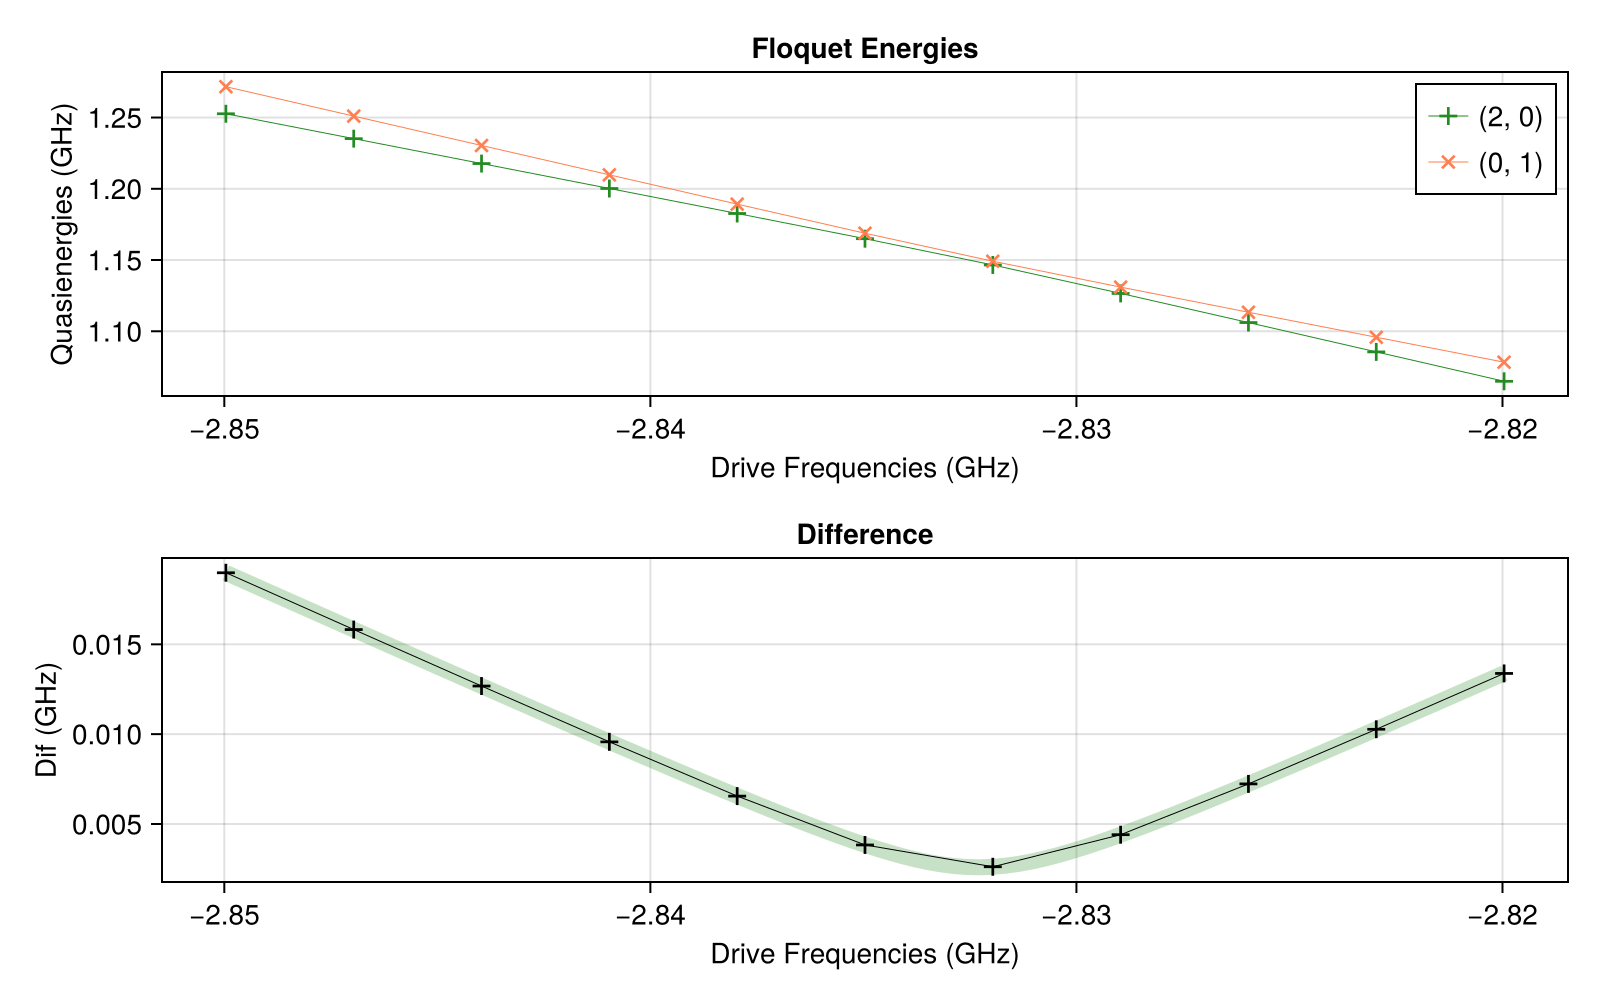

193.0435953925961

In [131]:
reference_states = Dict{Any, Any}((0,1) => circuit.dressed_states[(0,1)], (2,0) => circuit.dressed_states[(2,0)])
stark_shifts = LinRange(0.02, 0.05, 11)
res_res = SCC.Dynamics.find_resonance(circuit.H_op, circuit.ops["nt"], base_freq.+stark_shifts, amplitude, reference_states; show_plot = true)

drive_coef_param.frequency = res_res[1]
drive_coef_param.drive_time = res_res[2]


### Calibrating Drive Time

In [132]:
psi0 = circuit.dressed_states[(2,0)]
psi_targ = circuit.dressed_states[(0,1)]
to_min(psi) = 1-abs(psi_targ'*psi)^2
#drive = SCC.Dynamics.calibrate_drive_time(drive_coef_param, circuit, "nt", [res_res[2], res_res[2]+2*ramp_time], psi0, to_min);
drive_coef_param.drive_time = 1000
drive_param = SCC.Dynamics.CircuitDriveParam(op = "nt", coef_param = drive_coef_param)
drive = SCC.Dynamics.get_drive(circuit, drive_param);

In [3]:
sort(vcat(0:0.25:1.3, [0.3, 0.4]))

8-element Vector{Float64}:
 0.0
 0.25
 0.3
 0.4
 0.5
 0.75
 1.0
 1.25

In [134]:
res = qt.sesolve(2*pi*(drive.drive+circuit.H_op), psi0, 0:0.01:drive.drive_time, maxiters = 1e8)

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 11s (ETA: 0h 00m 00s)


Solution of time evolution
(return code: Success)
--------------------------
num_states = 100001
num_expect = 0
ODE alg.: OrdinaryDiffEqTsit5.Tsit5{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}(OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, static(false))
abstol = 1.0e-8
reltol = 1.0e-6


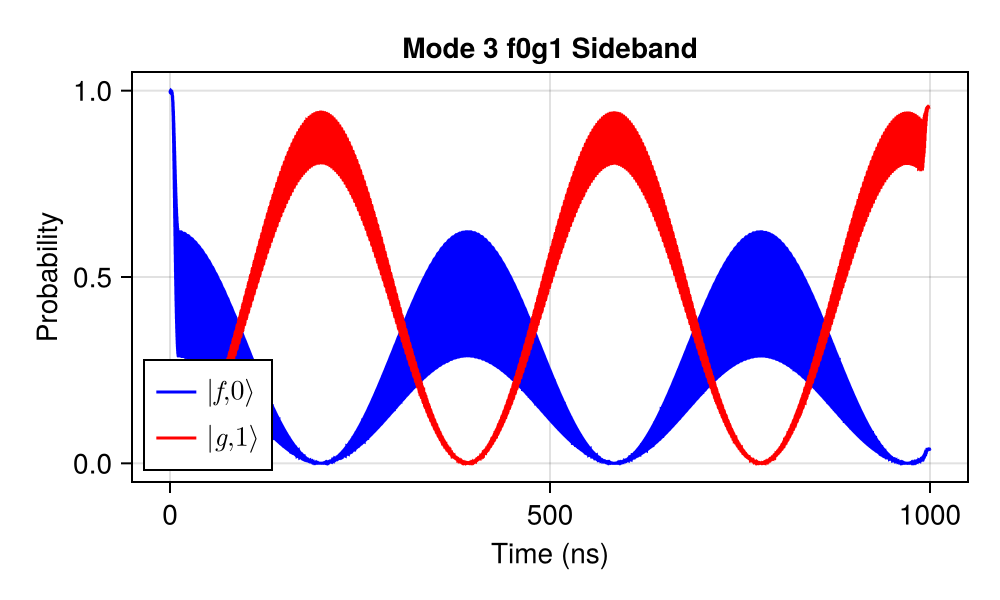

CairoMakie.Screen{IMAGE}


In [135]:
fig = cm.Figure(size = (500, 300))
ax = fig[1, 1] = cm.Axis(fig; title = "Mode 3 f0g1 Sideband", xlabel = "Time (ns)", ylabel = "Probability")
x = res.times

y = [abs(psi0'*res.states[i])^2 for i in 1:length(res.states)]


cm.lines!(ax, x, y; color = :blue, label = cm.L"$|f,0\rangle$")

y = [abs(psi_targ'*res.states[i])^2 for i in 1:length(res.states)]
cm.lines!(ax, x, y; color = :red, label = cm.L"$|g, 1\rangle$")
cm.axislegend(ax, position = :lb)
display(fig)


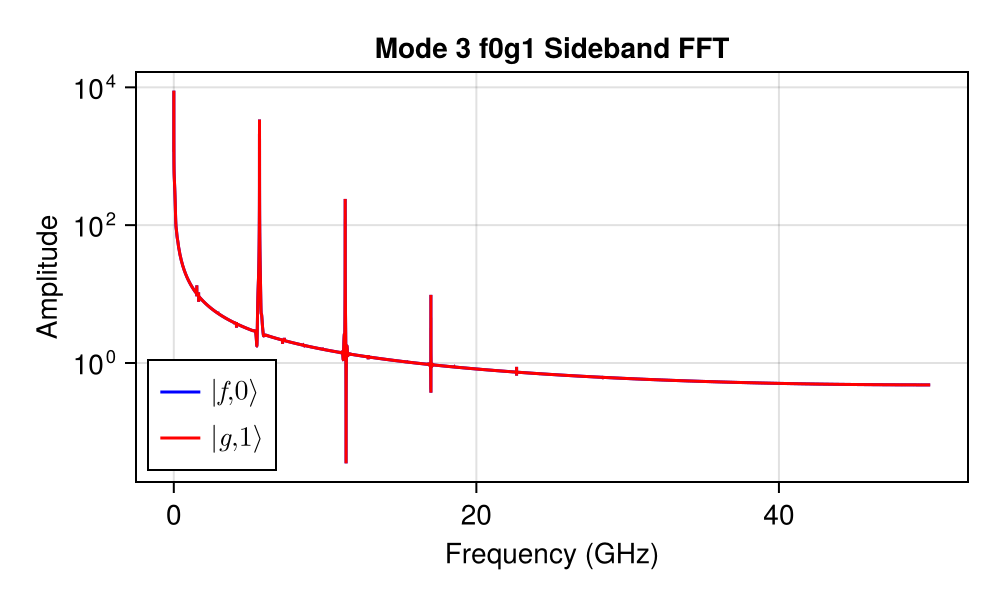

CairoMakie.Screen{IMAGE}


In [117]:
y_init = [abs(psi0'*res.states[i])^2 for i in 1:length(res.states)];
fft_init_res = fft(y_init);
Fs = 1/(res.times[2]-res.times[1])
frequencies_init = (0:length(fft_init_res)-1) * Fs / length(fft_init_res);

y_final = [abs(psi0'*res.states[i])^2 for i in 1:length(res.states)];
fft_final_res = fft(y_final);
Fs = 1/(res.times[2]-res.times[1])
frequencies_final = (0:length(fft_final_res)-1) * Fs / length(fft_final_res);

fig = cm.Figure(size = (500, 300))
ax = cm.Axis(fig[1,1],  title = "Mode 3 f0g1 Sideband FFT", xlabel = "Frequency (GHz)", ylabel = "Amplitude", yscale = cm.log10)
x = frequencies_init[1:div(length(fft_init_res),2)][2:end]
y = abs.(fft_init_res[1:div(length(fft_init_res),2)])[2:end]
cm.lines!(ax, x, y; color = :blue, label = cm.L"$|f,0\rangle$")

x = frequencies_final[1:div(length(fft_final_res),2)][2:end]
y = abs.(fft_final_res[1:div(length(fft_final_res),2)])[2:end]
cm.lines!(ax, x, y; color = :red, label = cm.L"$|g, 1\rangle$")

cm.axislegend(ax, position = :lb)
display(fig)



In [10]:
fieldnames(typeof(circuit))

(:H_op, :dressed_energies, :dressed_states, :dims, :order, :loss_ops, :components, :interactions, :stuff, :drives, :gates, :ops, :io_stuff, :dressed_order)

In [11]:
circuit.interactions

1-element Vector{Vector{Any}}:
 [0.026877206812551357, ":n_op", "1im*(:a_op-:a_op')"]

In [15]:
fieldnames(typeof(circuit.components["resonator"]))

(:dim, :params, :H_op, :eigenstates, :eigenenergies, :loss_ops, :a_op, :N_op)

In [18]:
circuit.components["resonator"].params

Dict{Symbol, Any} with 5 entries:
  :Eosc    => 6.22808
  :N       => 10
  :kappa_c => 1.0e-6
  :name    => "resonator"
  :kappa_d => 0

In [21]:
circuit.ops

Dict{String, Any} with 1 entry:
  "nt" => …

In [126]:
Vector{Tuple}(undef, 10)

10-element Vector{Tuple}:
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef